# Section 5. Bigrams and Langauge Models

## What is a Bigram?
- Bi == 2
- Bigram is a sequence of 2 consecutive words
- N-grams: a sequence of N consecutive words

## Bigram Model
- **The BIGRAM MODEL means that we are going to model each possible bigram as a probability**: $p(w_t | w_t-1)$
- We want to find the probability of w given the previous word
- we find these probabilities is just counting

Example:
- sentence: "the quick brown fox jumps over the lazy dog"
- find $p("brown" | "quick")$
    - How many times does "quick" -> "brown" appear in my set of documents
    - how many times does "quick" appear in my set of documents
    - Divide these! This gives me the 'maximum likelihodd probability'
    
$$p(brown|quick) = \frac{count(quick\rightarrow brown)}{count(quick)}$$

## ABC Example
- Lets find probability of the sentance "A B C": $p(A\space B\space C)$
- Apply bayes rules:
    - $p(A\rightarrow B\rightarrow C) = p(C\space| \space A\rightarrow B) * p(A\rightarrow B)$
    
 
- However we can essentially keep applying Bayes rule for each word in the sequence. This is called **The Chain Rule of Probability**:
    - $p(A\rightarrow B\rightarrow C) = p(C\space| \space A\rightarrow B) * p(B \space | \space A) * p(A)$
    
  
    
## Breaking down the probability chain
### Unigram
- p(A): simple probabilitiy count
    - p(A) = count(A) / total num of words in corpus


- p(C | A->B): Trigram
    - p(C | A -> B) = count(A->B->C) / count(A->B)
   
## A longer Sentence
- We can extend the Chain Rule loigc to sentences of any length. Take the sentance "A B C D E":
    - $p(A, B, C, D, E) = p(E\space| \space A, B, C, D) * p(D\space| \space A, B, C) * p(C\space| \space A, B)*p(B \space | \space A) * p(A)$
    - *Note that we've replaces the arrow with a comma to save space, but it should be understood that we are looking at a sequence and NOT simply a joint probability.*
    
### You can see that at some point, modeling these n-grams becomes problematic.**
- Consider: 
    - p(dog | the quick brown fox jumps over the)
- "the quick brown fox jumps over the lazy TURTLE is also a totally legit sentence, but it may not show up in our corpus, its maximum likelehood probability will be zero!
    - p(turtle | the quick brown fox jumps over the) = 0
- 0 obviously isnt ideal, because this sentance makes sense... 

## Add-one smoothing

- one way to deal with this issue is to use add-one smoothing:
    - instead of using maximum likelihood counting, we add a small number to each count!
    - $p_{smooth}(B\space |\space A) = \frac{count(A \rightarrow B)+1}{count(A)+V}$

    - note: V = vocabulary size = number of distinct words
    - Divide by V in denominator to ensure probabilities sum to 1... which is necessary to form valid prob distribution
    - **SO, even if the sentence does not show up in corpus, it will still have a SMALL probability**

### The Markov Assumption
- "What I see now depends ONLY on what I saw in the previous step"
- In other words, any older terms just disapear.
- first order Markov:
    - $p(w_t\space |\space w_{t-1},\space w_{t-2},...,\space w_{t-n}) = p(w_t\space |\space w_{t-1})$
- SO, essentially a first order Markov assumption means that the next term depends ONLY on the previous SINGLE term. A SECOND ORDER MARKOV would mean that the next term depends on the previous TWO TERMS, and a third order Markov assumption would mean that the next term depends on the next THREE TERMS... and so on, and so on. 

## First Order Markov (ie only using bigrams)
- $p(A, B, C, D, E) = p(E\space| \space D) * p(D\space| \space C) * p(C\space| \space B)*p(B \space | \space A) * p(A)$
- So using the first order markov assumption, **the joint probability function for the sentence "A B C D E" becomes a series of bigrams and a single unigram**. 

#### KEY: Its easier to model the probability of shorter phrases because we have more samples, and this makes a realistic sentence like "the quick brown fox jumps over the lazy TURTLE" more probable. 
  
    

    

# Bigrams Code Exercise
In this exercise, we will develop a bigrams model to predict the next word in a sentence.

In [2]:
# Course URL:
# https://deeplearningcourses.com/c/natural-language-processing-with-deep-learning-in-python
# https://udemy.com/natural-language-processing-with-deep-learning-in-python

import numpy as np
import os
import sys
import operator
from nltk.corpus import brown
import nltk
import pandas as pd

## 1. Create functions from rnn class

Just creating functions that take our tokenized sentences from the nltk brown corpus and convert them to word index representations. 

In [3]:
#GET SENTENCES FROM BROWN CORPUS
def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()
test = get_sentences()

In [4]:
#SENTANCES TO INDEX REPRESENTATION
def get_sentences_with_word2idx(print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    
    #loop through all sentances, add unique words to index
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            #convert each sentance to index map
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    if print_v:
        print("Vocab size:", i)
    return indexed_sentences, word2idx

In [5]:
#SENTANCES TO INDEX REPRESENTATION WITH LIMITED VOCAB
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS, print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    
    #Set start tokens to inf so they dont get removed when sorting by count
    word_idx_count = {
    0: float('inf'),
    1: float('inf'),
    }
    
    #Count each word 
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1
            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size
    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')
    #tell sorted funciton to use 2nd item to sort
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    #create new dictionary from old dict
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        if print_v:
            print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    # replcae all infrequent words are replaced with 'UNKOWN"
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx
    
    # sanit check to make sure all words wanted to keep are still there
    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

# 2. Generate test data
- raw sentences
- tokenized sentences
- word index of test corpus
- word index representation of sentences

In [1]:
# CREATE TEST DATA
from sklearn.feature_extraction.text import CountVectorizer
sentences_raw = ["hey there im mike",
                 "hi my dudes im suzy",
                 "hi guys im jonh",
                 "hey yall im jane",
                 "wasssup my names tracy",
                 "hey guys im mike",
                ]
test_sentences_tok = [sent.split() for sent in sentences_raw] #tokenize
vectorizer = CountVectorizer() #init vectorizer
vector = vectorizer.fit_transform(sentences_raw)

#CREATE WORD MATRIX, ADD START AND END INDEX
word_index = vectorizer.vocabulary_ #extract vocab index
test_word_index = {index:key+2 for index, key in word_index.items()}
test_word_index['START'] = 0
test_word_index['END'] = 1

#create wordindex representations of sentences, add 2 for START and END
test_sentences_idx = [[test_word_index[token] for token in sentence] for sentence in test_sentences_tok] 

print(test_sentences_tok)
print('\n',test_word_index)
print('\n',test_sentences_idx)

[['hey', 'there', 'im', 'mike'], ['hi', 'my', 'dudes', 'im', 'suzy'], ['hi', 'guys', 'im', 'jonh'], ['hey', 'yall', 'im', 'jane'], ['wasssup', 'my', 'names', 'tracy'], ['hey', 'guys', 'im', 'mike']]

 {'hey': 4, 'there': 13, 'im': 6, 'mike': 9, 'hi': 5, 'my': 10, 'dudes': 2, 'suzy': 12, 'guys': 3, 'jonh': 8, 'yall': 16, 'jane': 7, 'wasssup': 15, 'names': 11, 'tracy': 14, 'START': 0, 'END': 1}

 [[4, 13, 6, 9], [5, 10, 2, 6, 12], [5, 3, 6, 8], [4, 16, 6, 7], [15, 10, 11, 14], [4, 3, 6, 9]]


# 3. Create 'get_bigrams_probs' function

Create a function that extracts the bigram probabilities from a corpus of tokenized sentences and puts them into a matrix. The structure of the matrix will be as follows:
    - The row index -> index the PREVIOUS word
    - The column index -> index the CURRENT word
    - (last word, current word) -> probabilitiy
    - we will use add one smoothing

In [7]:
def get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # initialize bigram_probs with size vocab * vocab
    # set all values as 1s and multiple mby smoothing (this will ensure minimum values is 1*smoothing value)
    bigram_probs = np.ones((V, V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            # begining word... add 1 to col row[0] (previous word) and col[i] (current word)
            # we loop through sentence items because they are in indexed format, so we can use values as indeces
            if i==0:
                bigram_probs[start_idx, sentence[i]] += 1
            else: #middle word
                bigram_probs[sentence[i-1], sentence[i]] += 1
            # if we're at the final word
            # we update the bigram for last -> current, AND current -> END token
            if i == len(sentence) - 1: # END word
                bigram_probs[sentence[i], end_idx] += 1
    # normalize the counts along the rows to get probabilities
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs

In [8]:
# RUN FUNCITON WITH TEST DATA
test_bigram_probs = get_bigrams_probs(test_sentences_idx, len(test_word_index), test_word_index['START'], test_word_index['END'], smoothing=0.01)

# VISUALISE TEST DF
sorted_vocab = sorted(test_word_index, key=test_word_index.get) #get sorted vocab list
test_df = pd.DataFrame(test_bigram_probs, columns=sorted_vocab, index=sorted_vocab) #set dataframe

#NOTE: use highlight_max and set_precision style features for easy viewing
test_df = test_df.style.highlight_max(subset=None, color='yellow', axis=1).set_precision(2)
test_df

,START,END,dudes,guys,hey,hi,im,jane,jonh,mike,my,names,suzy,there,tracy,wasssup,yall
START,0.0016,0.0016,0.0016,0.0016,0.49,0.33,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.16,0.0016
END,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059,0.059
dudes,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.86,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085
guys,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.93,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046
hey,0.0032,0.0032,0.0032,0.32,0.0032,0.0032,0.0032,0.0032,0.0032,0.0032,0.0032,0.0032,0.0032,0.32,0.0032,0.0032,0.32
hi,0.0046,0.0046,0.0046,0.47,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.47,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046
im,0.0019,0.0019,0.0019,0.0019,0.0019,0.0019,0.0019,0.2,0.2,0.39,0.0019,0.0019,0.2,0.0019,0.0019,0.0019,0.0019
jane,0.0085,0.86,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085
jonh,0.0085,0.86,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085,0.0085
mike,0.0046,0.93,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046,0.0046


#### So we can see from the above matrix that:
- START is most likely followed by "hey"
- "hi" is most likely follows by "guys"
- "dudes" is most likely followed by "im"

# 4. Create 'get_scores function'

To get a 'score' of a random sentence, we simply add up all of the probabilities of the individual bigrams. 

### Using Log Probabilitiy
We use log probability instead of just summing probabilities, this is because:
- very unlikely sentences will have many unlikely bigram probas multiplied together
- if you multiply too many small probabilities together, you may encounter the **underflow problem** (basically your answer gets rouned to 0, or you get an error or something...)
- so we use log proba to avoid this problem
- NOTE: The Log function is **monotonically increasing**. So if A is greater than B, then log(A) is greater than log(B)

### Adding Log probabilities
Note that we when trying to find the joint probabilities, we add (not multiply) the independent LOG probabilities.
- instead of "$p_{AB} = p_A\cdot p_B$" (when you have independence), one can instead write "$\log(p_{AB}) = \log(p_A)+ \log(p_B)$". 
- If you need the actual probability, you can exponentiate at the end to get back pAB: $\qquad p_{AB}=e^{\log(p_A)+ \log(p_B)}\,$, but if needed at all, the exponentiation would normally be left to the last possible step.

### Normalize each sentence
We normalize the log probabilities as well because:
- The log of a values between 0 and 1 (like a probability value) is negative (ie, log probabilites are always less than 0) 
- This means that **the longer the sentences, the more negative numbers we are going to add together**
- So if we compare raw log probabilities, we are always going to have a bias towards shorter sentences (ie, fewer bigrams and fewer negative probabilities added together).
- To solve this problem, we divide the log probabilities, by the length of the sentence (T) (we will see this in the code below)

![](pictures/nlp_5_logprobas.jpg)

In [12]:
pA = 0.8
pB = 0.3
pAB = pA * pB
print('P(A) * P(B)=', pAB)

logpAB = np.log(pA) + np.log(pB)
print('log(P(A)) + log(P(B))=',np.exp(logpAB))

P(A) * P(B)= 0.24
log(P(A)) + log(P(B))= 0.24


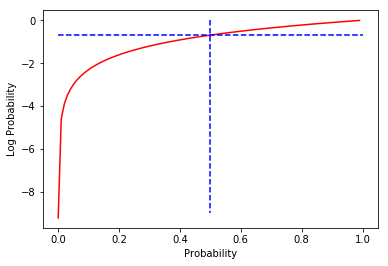

In [128]:
#GRAPH LOG PROBA VS PROBA
import matplotlib.pyplot as plt
def plot_logprob(proba=None):
    probs = np.arange(0.0001,1,0.01) #generate probas from 0 to 1
    log_probs = [np.log(x) for x in probs] #generate log probs for each proba
    plt.plot(probs,log_probs, 'r')
    if proba:
        #plot horizontal line (proba val)
        horiz = np.arange(0,-10,-1)
        plt.plot(np.repeat(proba,len(horiz)),horiz,'b--')
        #plot vertical line (log(proba) val)
        vert = np.arange(0,1.1,0.1)
        plt.plot(vert,np.repeat(np.log(proba),len(vert)),'b--')
    plt.xlabel('Probability')
    plt.ylabel('Log Probability')
    plt.show()

plot_logprob(proba=0.5)

In [14]:
#create a function to turn sentences into word vector representations, for testing!
def sent_to_wvr(sentence, word_index=test_word_index):
    tokens = sentence.split()
    wvr = []
    for token in tokens:
        wvr.append(word_index[token])
    return wvr

print(test_word_index)
sent_to_wvr('hi im mike')

{'hey': 4, 'there': 13, 'im': 6, 'mike': 9, 'hi': 5, 'my': 10, 'dudes': 2, 'suzy': 12, 'guys': 3, 'jonh': 8, 'yall': 16, 'jane': 7, 'wasssup': 15, 'names': 11, 'tracy': 14, 'START': 0, 'END': 1}


[5, 6, 9]

In [272]:
#CREATE GET SCORE FUNCTION (WITH LOG)
def get_score_log(sentence, bigram_probs=bigram_probs, start_idx=0, end_idx=1, return_proba=False):
    score = 0
    for i in range(len(sentence)):
        if i == 0:
            #if first word, take start index and sentance index prob, add log proba to score
            score += np.log(bigram_probs[start_idx, sentence[i]])
        else:
            #if middle word select i-1 row (preceding word), and i col (current word), add log proba to score
            score += np.log(bigram_probs[sentence[i-1], sentence[i]])
        #final word... probability that the word is the last word in sentence
    score += np.log(bigram_probs[sentence[-1], end_idx])
    #normalize score so we dont bias shorter sentences
    if return_proba:
        return str(np.exp(score / (len(sentence)+1))*100)+' percent'
    return score / (len(sentence)+1)
        

#CREATE GET SCORE FUNCTION (WITHOUT LOG)
def get_score_basic(sentence, bigram_probs=bigram_probs, start_idx=0, end_idx=1):
    for i in range(len(sentence)):
        if i == 0:
            #if first word, take start index and sentance index prob, add log proba to score
            score = bigram_probs[start_idx, sentence[i]]
        else:
            #if middle word select i-1 row (preceding word), and i col (current word), add log proba to score
            score *= bigram_probs[sentence[i-1], sentence[i]]
        #final word... probability that the word is the last word in sentence
    score *= bigram_probs[sentence[-1], end_idx]
    #normalize score so we dont bias shorter sentences
    return np.log(score) / (len(sentence)+1)

sent = sent_to_wvr('hi im mike')
bigram_probs = test_bigram_probs

print('basic: ', get_score_basic(sent))
print('log:  ', get_score_log(sent))

basic:  -9.54265335995
log:   -9.54265335995


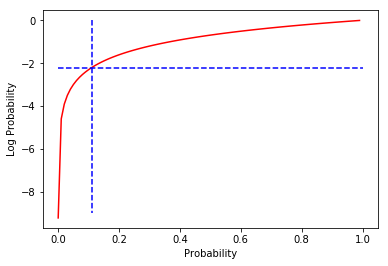

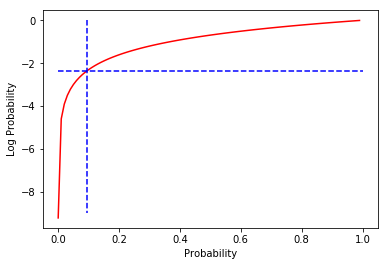

In [137]:
sent1 = sent_to_wvr('hi im mike')
sent2 = sent_to_wvr('hi yall im suzy')
plot_logprob(np.exp(get_score_log(sent1)))
plot_logprob(np.exp(get_score_log(sent2)))

# 5. Create 'get_words' function

This funciton simply converts sentences back to token word representations from word index representation.

In [144]:
# a function to map word indexes back to real words
idx2word = dict((v, k) for k, v in test_word_index.items())
def get_words(sentence):
    return ' '.join(idx2word[i] for i in sentence)

get_words(test_sentences_idx[0])

'hey there im mike'

# 6. Run the model!

#### Extract data from brown corpus

In [145]:
# load in the data
# note: sentences are already converted to sequences of word indexes
# note: you can limit the vocab size if you run out of memory
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(10000)

#### Extract parameters (V, start_idx, end_idx, bigram_probs, idx2word)

In [273]:
V = len(word2idx)
start_idx = word2idx['START']
end_idx = word2idx['END']
print("Vocab size:", V)
print("Start index:", start_idx)
print("End index:", end_idx)

# Get bigrams matrix: value at [row, col] = p(current word | last word)
bigram_probs = get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=0.1)

# a function to map word indexes back to real words
idx2word = dict((v, k) for k, v in word2idx.items())
def get_words(sentence):
    return ' '.join(idx2word[i] for i in sentence)

Vocab size: 10001
Start index: 0
End index: 1


#### Set up fake word probs

In [214]:
# when we sample a fake sentence, we want to ensure not to sample
# start token or end token
# so are essentiall making ALL probas equal for each word EXCEPT FOR 0 and 1 elements... 
# This is kind of a stupid way to do this tbh, but I've spent far too long on this wb... moving on!
sample_probs = np.ones(V)
sample_probs[start_idx] = 0
sample_probs[end_idx] = 0
sample_probs /= sample_probs.sum()
sample_probs

array([ 0.        ,  0.        ,  0.00010001, ...,  0.00010001,
        0.00010001,  0.00010001])

#### Create some fake sentences

In [280]:
#pick random sentence
sent_actual_idx = np.random.choice(len(sentences))
sent_actual = sentences[sent_actual_idx]
random_len = len(actual_sent)

# fake sentence
sent_fake = np.random.choice(V, size=random_len, p=sample_probs)

print("REAL:", get_words(sent_actual), "SCORE:", get_score_log(sent_actual,return_proba=True))
print()
print("FAKE:", get_words(sent_fake), "SCORE:", get_score_log(sent_fake,return_proba=True))

REAL: the dark UNKNOWN of the early work were UNKNOWN by a brighter UNKNOWN . SCORE: 1.18451249862 percent

FAKE: harbor ( seas dominate guessing SCORE: 0.00610645506235 percent


# Conclusion

NICE! It seems that fake sentences consistently score lower (and are thus more likely to be fake). Keep rerunning the above cell to try out random sentences. Also, check out the code below if you want to put this into a script and create a more interactive command line program!



      # test our model on real and fake sentences
      while True:
        # real sentence
        real_idx = np.random.choice(len(sentences))
        real = sentences[real_idx]

        # fake sentence
        fake = np.random.choice(V, size=len(real), p=sample_probs)

        print("REAL:", get_words(real), "SCORE:", get_score(real))
        print("FAKE:", get_words(fake), "SCORE:", get_score(fake))

        # input your own sentence
        custom = input("Enter your own sentence:\n")
        custom = custom.lower().split()

        # check that all tokens exist in word2idx (otherwise, we can't get score)
        bad_sentence = False
        for token in custom:
          if token not in word2idx:
            bad_sentence = True

        if bad_sentence:
          print("Sorry, you entered words that are not in the vocabulary")
        else:
          # convert sentence into list of indexes
          custom = [word2idx[token] for token in custom]
          print("SCORE:", get_score(custom))


        cont = input("Continue? [Y/n]")
        if cont and cont.lower() in ('N', 'n'):
          break
